In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import numpy as np
import skimage.io
import skimage.exposure
import matplotlib.pyplot as plt
import matplotlib.colors
from pathlib import Path
import tensorflow as tf
from tqdm import tqdm
from massimal import annotation, image_render, hyspec_cnn
import sklearn.metrics
import json

In [3]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

In [4]:
# Paths
val_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v2/val/')
water_mask_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/watermask/')
rgb_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/annotation/rgb_images/')
unet_model_path = Path('/home/mha114/data/massimal/vega_sola/hyperspec/models/geohab_unet_log_rrs_v2/2024-05-01-15h09m16s/unet_model.depth3.epoch108-loss0.059994-acc0.681.hdf5')

rgb_ann_pred_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/figures/geohab_2024/val_im_rgb_ann_pred/')
pred_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/figures/geohab_2024/val_im_pred/')
ann_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/figures/geohab_2024/val_im_ann/')
figure_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/figures/geohab_2024/figures/')
figure_dir.mkdir(exist_ok=True)

In [5]:
# Parameters
PAD_MULTIPLE = 8
ORIGINAL_WIDTH_PIXELS = 900

grouped_class_indices = {
    'Sand': {9}, 
    'Bedrock': {4}, 
    'Maerl': {33}, 
    'Rockweed': {19, 20, 21, 22, 23, 25, 26, 27}, 
    'Kelp': {13, 14, 15}, 
    'Chorda filum': {29}, 
    'Brown algae (deep)': {12, 16, 17, 18, 24, 30}}

# Create custom colormap for classes (including background:0)
custom_cmap = matplotlib.colors.ListedColormap(colors=['darkgray',           # Background - darkgray 
                                                       'darkturquoise',   # Sand
                                                       'pink',            # Bedrock
                                                       'magenta',         # Maerl bed
                                                       'seagreen',        # Rockweed
                                                       'darkorange',      # Kelp 
                                                       'red',             # Chorda filum (alt. 'lime'?)
                                                       'brown'])          # Brown algae

In [6]:
# Define grouped classes
class_names = ['Background'] + [k for k in grouped_class_indices.keys()]
print(class_names)

['Background', 'Sand', 'Bedrock', 'Maerl', 'Rockweed', 'Kelp', 'Chorda filum', 'Brown algae (deep)']


In [7]:
# Set plotting info based on class info
cbar_vmin = 0
cbar_vmax = len(class_names)-0.01
cbar_ticks = [i+0.5 for i in range(len(class_names))]
cbar_ticklabels = class_names

print(cbar_ticks)
print(cbar_ticklabels)

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
['Background', 'Sand', 'Bedrock', 'Maerl', 'Rockweed', 'Kelp', 'Chorda filum', 'Brown algae (deep)']


In [8]:
# Get dataset paths, load and merge datasets
val_image_paths = [path for path in sorted(val_im_dir.glob('*'))]
val_images = tf.data.experimental.load(str(val_image_paths[0]))                # Load first image as initial dataset
for val_image_path in val_image_paths[1:]:                                # For every consecutive image,
    val_images = val_images.concatenate(tf.data.experimental.load(str(val_image_path)))     # Append to dataset

In [9]:
# Create list of image names
image_names = [path.stem for path in val_image_paths]

In [10]:
# Pad to multiple 
pca_images = []
label_images = []
for pca_im, label_im in val_images.as_numpy_iterator():
    pca_images.append(hyspec_cnn.pad_image_to_multiple(pca_im,PAD_MULTIPLE))
    label_images.append(hyspec_cnn.pad_image_to_multiple(label_im,PAD_MULTIPLE))

In [11]:
# Load RGB_images
rgb_images = []
for image_name in image_names:
    rgb_im_path = [path for path in rgb_im_dir.rglob(image_name+'.bip.png')][0]
    rgb_im = skimage.io.imread(rgb_im_path)
    rgb_im_padded = hyspec_cnn.pad_image_to_multiple(rgb_im,PAD_MULTIPLE)
    rgb_images.append(rgb_im_padded)

In [12]:
# Create masks for valid data (water, not saturated)
valid_data_masks = []
for image_name, pca_im in zip(image_names,pca_images):
    water_mask_path = [path for path in water_mask_dir.rglob(image_name+'.bip.png')][0]
    water_mask = skimage.io.imread(water_mask_path)
    water_mask = hyspec_cnn.pad_image_to_multiple(water_mask,PAD_MULTIPLE) != 0
    nonzero_mask = ~np.all(pca_im==0,axis=2)
    valid_data_masks.append(water_mask*nonzero_mask)

In [13]:
# Load UNet model 
unet = tf.keras.models.load_model(unet_model_path)

In [14]:
# Predict labels for all images
label_images_pred = []
for pca_im in tqdm(pca_images):
    label_images_pred.append(hyspec_cnn.unet_classify_single_image(unet,pca_im))

100%|██████████| 39/39 [00:38<00:00,  1.02it/s]


In [15]:
# for rgb_im, valid_mask, label_im, label_im_pred,image_name in tqdm(zip(
#         rgb_images, valid_data_masks, label_images,label_images_pred,image_names)):
#     fig,(ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(12,8))
#     im0 = ax0.imshow(rgb_im*np.expand_dims(valid_mask,axis=2))
#     ax0.set_title('RGB render')
#     im1 = ax1.imshow(label_im*valid_mask,cmap=custom_cmap,vmin=cbar_vmin,vmax=cbar_vmax,interpolation='none')
#     ax1.set_title('Annotation')
#     im2 = ax2.imshow(label_im_pred*valid_mask,cmap=custom_cmap,vmin=cbar_vmin,vmax=cbar_vmax,interpolation='none')
#     ax2.set_title('Predicted classes')
#     for ax in (ax0,ax1,ax2):
#         ax.set_xticks([])
#         ax.set_yticks([])
#     fig.subplots_adjust(right=0.8)                   # Make room for colorbar
#     cbar_ax = fig.add_axes([0.82, 0.175, 0.02, 0.65])  # [left, bottom, width, height] 
#     cbar = fig.colorbar(im1, cax=cbar_ax)
#     cbar.set_ticks(cbar_ticks)
#     cbar.set_ticklabels(cbar_ticklabels)
#     plt.savefig(rgb_ann_pred_im_dir/(image_name+'.png'),
#                 dpi=300,
#                 bbox_inches='tight',
#                 transparent=True)
#     plt.show()

In [16]:
# for label_im_pred,valid_mask,image_name in tqdm(zip(label_images_pred,valid_data_masks,image_names)):
#     label_im_pred = label_im_pred*valid_mask
#     label_im_pred = label_im_pred[:,0:ORIGINAL_WIDTH_PIXELS]
#     plt.imsave(
#         fname=pred_im_dir/(image_name+'.bip.png'),
#         arr=label_im_pred,
#         cmap=custom_cmap,
#         vmin=cbar_vmin,
#         vmax=cbar_vmax)


In [17]:
# for label_im,image_name in tqdm(zip(label_images,image_names)):
#     plt.imsave(
#         fname=ann_im_dir/(image_name+'.bip.png'),
#         arr=label_im,
#         cmap=custom_cmap,
#         vmin=cbar_vmin,
#         vmax=cbar_vmax)


In [18]:
# Make confusion matrix based on test images
y_true = []
y_pred = []

for valid_mask, label_im, label_im_pred in tqdm(zip(valid_data_masks, label_images,label_images_pred)):
    annotated_mask = label_im != 0
    y_true.append(label_im[valid_mask*annotated_mask])
    y_pred.append(label_im_pred[valid_mask*annotated_mask])

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Remove zero-valued predictions (only very few). Odd - check out.
nonzero_pred = (y_pred != 0)
y_true = y_true[nonzero_pred]
y_pred = y_pred[nonzero_pred]

confusion_matrix = sklearn.metrics.confusion_matrix(y_true,y_pred,normalize='true')

39it [00:00, 288.36it/s]


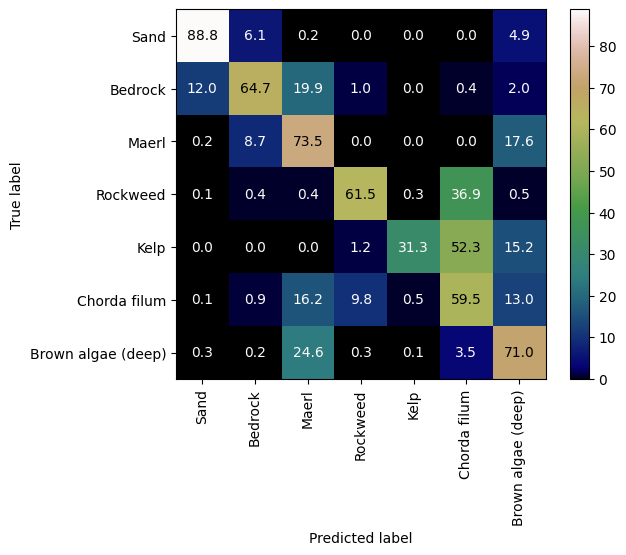

In [19]:
# Show confusion matrix
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=cbar_ticklabels[1:])
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.savefig(figure_dir/'vega_sola_confusionmatrix_depth3_withdropout_8firstchannels_weightedloss.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.show()

In [22]:
classification_report = sklearn.metrics.classification_report(y_true,y_pred)

In [23]:
print(classification_report)

              precision    recall  f1-score   support

           1       0.84      0.89      0.86   2864597
           2       0.76      0.65      0.70   3826572
           3       0.75      0.74      0.74   6610192
           4       0.75      0.61      0.68   1194793
           5       0.90      0.31      0.46    412513
           6       0.61      0.60      0.60   1916259
           7       0.46      0.71      0.56   2040285

    accuracy                           0.71  18865211
   macro avg       0.73      0.64      0.66  18865211
weighted avg       0.73      0.71      0.71  18865211

